In [646]:
import logLikeli

In [647]:
imp.reload(logLikeli)

<module 'logLikeli' from '/home/jianyao/Likelihood/logLikeli.py'>

In [648]:
from logLikeli import logLike

import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [2]:
import utils

In [161]:
from utils import Marray_EEfirst as Marray
from utils import Minv as Minv
from utils import evaluateLikelihood as evaluateL
from utils import combine_ps as combine_ps

In [4]:
import dynesty
from dynesty import plotting as dyplot
## import planck function 
from pysm.common import B as pf

In [5]:
from pysm.common import convert_units

In [22]:
from dynesty import utils as dyfunc 

In [6]:
from multiprocessing import Pool, cpu_count

In [157]:
import cmath

In [311]:
cmath.sqrt(-1)

1j

## data

In [94]:
A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
dust_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy')

A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')
sync_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy')

In [464]:
fl_pysm = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/fl_pysm.npy')

In [398]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'

cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); cl_f_ali = np.mean(cl_f_all_ali, axis = 0)

## to include the dust and sync cross ps into the fiducial ps. Only BB for now; 2020.07.13
# cl_f_all_ali[:,2] +=  sync_dl_RJ + dust_dl_RJ #

cl_hat_all_ali = np.load('%s/cl_hat_fore_all.npy'%path) 
# cl_hat_0_ali = cl_hat_all_ali[10]

# cl_hat_all_ali = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/cl_hat_r0_all.npy')

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

In [363]:
fl_pysm.shape

(3, 10, 2, 2)

In [366]:
cl_f_all_ali.shape

(500, 3, 10, 2, 2)

In [126]:
cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')
cl_th_BB_ali = cl_camb + nl_mean_ali[2]

In [9]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

In [60]:
cmb_bb = lensingB[2] + bb_05

b.bin_cell(cmb_bb[0:nmtlmax+1])

In [13]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

Nf = 2

b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

In [162]:
def combine_ps(r):
    
    '''
    Combine the tensor bb and lensing bb power spectrum of CMB.
    '''
    
    bb_tensor = bb_05[0:nmtlmax+1]*r/0.05 

    bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower, use simple window function
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]
        
    return cl_th_test

## Method

### decompose 

In [155]:
alpha_s = -1.2; alpha_d = -0.5; beta_s = -3.0; beta_d = 1.558; epsilon = 0.3;

Cl_test = combine_ps(0) + nl_mean_ali[2] + sync_ps(A_s_RJ[3], leff, alpha_s, beta_s) + dust_ps(A_d_RJ[3], leff, alpha_d, beta_d) \
        + corre_fore(epsilon, A_d_RJ[3], A_s_RJ[3], leff, alpha_s, alpha_d, beta_s, beta_d);

In [166]:
Cl_test.shape

(10, 2, 2)

In [226]:
def vecp(mat):
    '''
    This returns the unique elements of a symmetric matrix 
    '''

    dim = mat.shape[0]
    
    vec = np.zeros(int(dim*(dim+1)/2), dtype = np.complex)
    counter = 0
    for k in range(0,dim):
        vec[counter:counter+dim-k] = np.diag(mat,k)
        
        counter = counter + dim - k

    return vec

In [256]:
nf_ind = int(Nf*(Nf+1)/2)
    
Xall = np.ones(lbin*nf_ind, dtype = np.complex)    
for l in range(lbin):

    cl_f_12 = sqrtm(cl_f_ali[2][l])
    cl_inv = LA.pinv(Cl_test[l])
    cl_inv_12= sqrtm(cl_inv)

    res = np.dot(cl_inv_12, np.dot(cl_hat_all_ali[0][2][l], cl_inv_12))

    [d, u] = LA.eigh(res)
#     d = np.diag(d)  # noticed that python returns the eigenvalues as a vector, not a matrix
  
    gd = np.ones(Nf, dtype = np.complex);
    for i in range(Nf):
        
        gd[i] = np.sign(d[i] - 1) * cmath.sqrt(2 * (d[i] - np.log(d[i]) - 100))
        
    gd = np.diag(gd);
        
    # Argument of vecp in equation 8; multiplying from right to left     
    X = np.dot(np.transpose(u), cl_f_12)
    X = np.dot(gd, X)
    X = np.dot(u, X)
    X = np.dot(cl_f_12, X)
    # This is the vector of equation 7  
    Xall[l*nf_ind:(l+1)*nf_ind] = vecp(X)

Xa = np.matrix(Xall)

In [257]:
Xa*LA.inv(LogL.Cov)*np.transpose(Xa)

matrix([[-1839843.90914143+0.j]])

In [259]:
gd

array([[-0.-14.07119596j,  0. +0.j        ],
       [ 0. +0.j        ,  0.+14.07118426j]])

In [219]:
gd

array([[-0.-14.14208456j,  0. +0.j        ],
       [ 0. +0.j        ,  0.+14.14207292j]])

In [232]:
vecp(X)

array([0.-0.32121034j, 0.+0.21141468j, 0.-0.08981704j])

In [ ]:
LogL.run(cl_hat=cl_hat_all_ali[0][2], cl_th=Cl_test, sbin=1)

### init logL function 

In [641]:
imp.reload(utils)

<module 'utils' from '/home/jianyao/Likelihood/utils.py'>

In [642]:
from utils import testL as testL

In [649]:
LogL = logLike(2,10) 

 ## calculate logL.cl_f; logL.Cov  
LogL.M(cl_f_all = cl_f_all_ali, SamNum=500)

In [650]:
SamNum = 500

In [651]:
LogL.run(cl_hat=cl_hat_all_ali[0][2], cl_th=Cl_test, sbin=0, ebin = 10)

-94.00836767998676

In [17]:
sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

#### foreground cosmic variance

In [381]:
fl_pysm = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/fl_pysm.npy')

In [388]:
Fl_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/Fl_all_from_foreground_realizations.npy')

In [389]:
Fore_Cov_re = np.std(Fl_all, axis = 0)

In [384]:
X_fore.shape

(30,)

In [394]:
Fore_Cov_theory = np.ones_like(Fore_Cov_re[0])
for i in range(len(Fore_Cov_re[0])):
    Fore_Cov_theory[i] = X_fore[3*i]

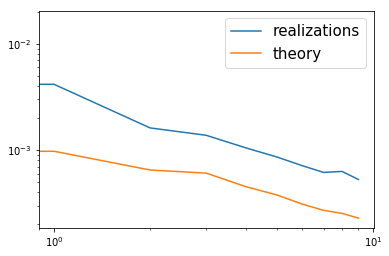

In [440]:
plt.loglog(Fore_Cov_re[0], label = 'realizations')
plt.loglog(Fore_Cov_theory, label = 'theory')
plt.legend(fontsize = 15)

In [382]:
X_fore = np.ones(lbin*3)
for i in range(lbin):
    
    X_fore[i*3:(i+1)*3] = utils.vecp(fl_pysm[2][i])*np.sqrt(2/((2*leff[i] + 1)*20))
    
Fore_Cov_th = np.diag(X_fore)

In [373]:
LogL.Cov += 0.001*Fore_Cov  ### Test foreground uncertainty; 0727  

In [346]:
LogL.Cov[0]

array([ 6.59732654e-03,  5.52457336e-07,  1.34393914e-06, -1.00714326e-07,
       -2.97963392e-08, -6.08825758e-08,  5.17528450e-09, -1.23995338e-08,
       -4.16131054e-09,  1.49728108e-08,  3.21245181e-08,  2.51867168e-08,
       -1.08539303e-08, -7.46696058e-09, -2.47745444e-09, -5.81866302e-08,
        3.13137962e-09, -5.18413668e-08,  1.33052582e-08, -3.98988629e-08,
       -8.98523995e-09,  1.27626787e-08,  1.12121257e-07,  2.80735822e-08,
        1.22903658e-08,  2.80762540e-08,  4.40246369e-08,  7.59575511e-08,
        5.66392992e-08,  4.72925245e-08])

In [354]:
LogL.Cov[0]

array([ 3.26996756e-06,  5.52457336e-07,  1.34393914e-06, -1.00714326e-07,
       -2.97963392e-08, -6.08825758e-08,  5.17528450e-09, -1.23995338e-08,
       -4.16131054e-09,  1.49728108e-08,  3.21245181e-08,  2.51867168e-08,
       -1.08539303e-08, -7.46696058e-09, -2.47745444e-09, -5.81866302e-08,
        3.13137962e-09, -5.18413668e-08,  1.33052582e-08, -3.98988629e-08,
       -8.98523995e-09,  1.27626787e-08,  1.12121257e-07,  2.80735822e-08,
        1.22903658e-08,  2.80762540e-08,  4.40246369e-08,  7.59575511e-08,
        5.66392992e-08,  4.72925245e-08])

### test input r=0 

In [83]:
npara = 3; Nsim = 30

def prior(cube):
    
    r = cube[0]*0.2 - 0.1
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8

    return [r, beta_s, beta_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);
for n in range(Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2]
      
    def log_likelihood(cube, subtract = False):
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];

        bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

        bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

        cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= cl_th_i[ell]

        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s_RJ, beta_s, 10) + dust_ps(A_d_RJ, beta_d, 10);
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1);   

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested(dlogz = 0.1)
        results = sampler.results
    
    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights]
    
#     mean, cov = dyfunc.mean_and_cov(samples, weights) 
    
#     Mean[n] = mean

In [56]:
resamples = dyfunc.resample_equal(samples, weights)

print(np.mean(resamples[:,0]))
print(np.std(resamples[:,0]))

print(np.mean(resamples[:,1]))
print(np.std(resamples[:,1]))

print(np.mean(resamples[:,2]))
print(np.std(resamples[:,2]))

0.001766507136861076
0.006820990723935475
-2.9903406149686047
0.0786657363610382
1.549191064673645
0.008951244490172764


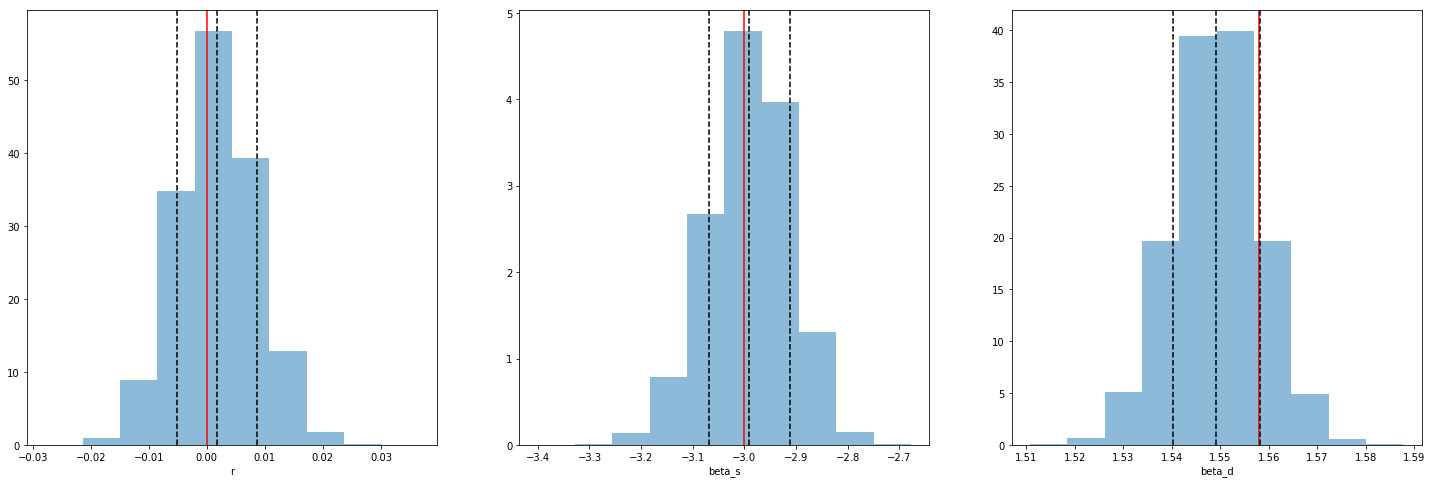

In [58]:
truth = [0, -3.0, 1.558];

fig, axes = plt.subplots(1,npara, figsize = (25,8))

paras = ['r', 'beta_s', 'beta_d']
for m in range(npara):
    
    axes[m].hist(resamples[:,m], density=True, alpha = 0.5); 
    axes[m].axvline(truth[m], c = 'r')
    axes[m].axvline(np.mean(resamples[:,m]),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] + np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] - np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].set_xlabel(r'%s'%paras[m])


(<Figure size 1080x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56f8307908>,
       dtype=object))

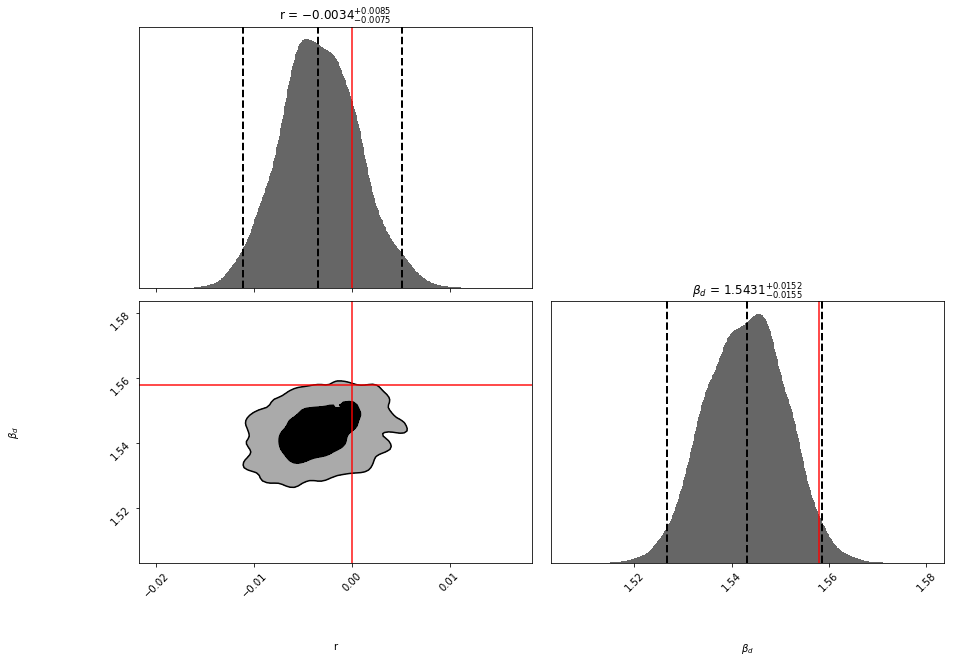

In [30]:
labels = ['r',r'$\beta_d$']; npara = 2
fig, axes = plt.subplots(npara,npara, figsize=(15, 10))
axes = axes.reshape((npara,npara))

truth = [0, 1.558]

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85


### complex foreground model

#### model test

In [122]:
dl_alpha = dust_ps(A_d_RJ[3], leff, -0.5, 1.558)
sl_alpha = sync_ps(A_s_RJ[3], leff, -1.2, -3.0)

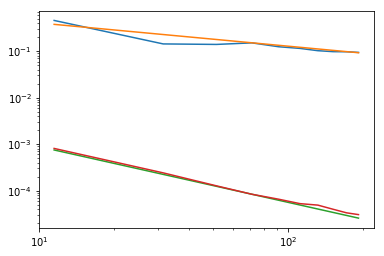

In [123]:
plt.loglog(leff, dust_dl_RJ[:,1,1])
plt.loglog(leff, dl_alpha[:,1,1])

plt.loglog(leff, sl_alpha[:,1,1])
plt.loglog(leff, sync_dl_RJ[:,1,1])

In [72]:
def dust_ps(A_d, ells, alpha_d, beta_d, nu = np.array([95, 150]), nu0 = 353, T_d = 19.6):
    
    '''
    Input
    -------------------------
    A_d : PS template at reference frequency at around 80; input in **uK_RJ** units.
    ells : exact ls for each l-bin; 
    beta_d : spectra index to be determined from likelihood analyis.
    
    Output
    -------------------------
    Cross power spectra for dust component, output in **uK_CMB** units.
    
    '''
    Nf = len(nu); lbin = len(ells)
    coeff = convert_units("uK_RJ", "uK_CMB", nu);
    dl = np.ones((lbin, Nf, Nf));
    
    b0 = pf(nu0, T_d); b12 = pf(nu, T_d);    
    
    factors = np.ones((Nf, Nf))
    for i in range(Nf):
        for j in range(Nf):
            factors[i][j] = b12[i]*b12[j]/b0**2
    
    for ell in range(lbin):
        
        for i in range(Nf): 
            for j in range(Nf):
                
                dl[ell, i,j] = A_d*(ells[ell]/71.5)**alpha_d*(nu[i]*nu[j]/nu0**2)**(beta_d - 2)*factors[i,j]*coeff[i]*coeff[j]
                
    return dl


def sync_ps(A_s, ells, alpha_s, beta_s, nu = np.array([95, 150]), nu0 = 30):
    
    '''
    Input
    -------------------------
    A_s : PS template at reference frequency at each lbin; input in **uK_RJ** units.
    ells : exact ls for each l-bin; 
    
    beta_s : spectra index to be determined from likelihood analyis.
    
    Output
    -------------------------
    Cross power spectra for dust component, output in **uK_CMB** units.
    
    '''    
    
    Nf = len(nu); lbin = len(ells)
    coeff = convert_units("uK_RJ", "uK_CMB", nu);
    sl = np.ones((lbin, Nf, Nf));
    
    for ell in range(lbin):
        
        for i in range(Nf): 
            for j in range(Nf):
                sl[ell, i, j] = A_s*(ells[ell]/71.5)**alpha_s*(nu[i]*nu[j]/nu0**2)**(beta_s)*coeff[i]*coeff[j] ;
                
    return sl

def corre_fore(epsilon, A_d, A_s, ells, alpha_s, alpha_d, beta_s, beta_d, nu = np.array([95, 150]), nu_s0 = 30, nu_d0 = 353):
    
    Nf = len(nu); lbin = len(ells)
    coeff = convert_units("uK_RJ", "uK_CMB", nu);
    
    fl = np.ones((lbin, Nf, Nf));
    
    f = epsilon*np.sqrt(A_s*A_d); 
    
    for ell in range(lbin):
        for i in range(Nf): 
            for j in range(Nf):
                
                fl[ell, i, j] =f*(ells[ell]/71.5)**((alpha_s + alpha_d)/2)*(f_d(nu[i], beta_d)*f_s(nu[j], beta_s) + f_d(nu[j], beta_d)*f_s(nu[i], beta_s))*coeff[i]*coeff[j]  
                                                                            
    return fl

def f_d(nu, beta_d, nu0 = 353, T_d = 19.6):
    
    return (nu/nu0)**(beta_d - 2)*pf(nu, T_d)/pf(nu0, T_d)
    
def f_s(nu, beta_s, nu0 = 30):
    
    return (nu/nu0)**beta_s

#### likelihood for foreground only

In [476]:
npara = 7; Nsim = 1; sbin = 0;

def prior(cube):
    
    beta_s = cube[0]*2 - 4## from -4 to -2
    beta_d = cube[1]*0.4 + 1.4 ## from 1.4 to 1.8
    
    # -1.2
    alpha_s = cube[2]*0.6 - 1.5
    
    #-0.5
    alpha_d = cube[3]*0.6 - 0.8
    
    epsilon = cube[4]*2 - 1
    
    A_s = cube[5]; A_d = cube[6] ## from 0 to 1; in uK_RJ units
    
    return [beta_s, beta_d, alpha_s, alpha_d, epsilon, A_s, A_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);

for n in range(Nsim):
    
    cl_hat_fore_ali = fl_pysm[2]; #cl_hat_all_ali[n][2]
      
    def log_likelihood(cube, subtract = False):

        beta_s = cube[0]; beta_d = cube[1];
        
        alpha_s = cube[2]; alpha_d = cube[3]; 
        
        epsilon = cube[4];
        
        A_s = cube[5]; A_d = cube[6]
        C_l = sync_ps(A_s, leff, alpha_s, beta_s) + dust_ps(A_d, leff, alpha_d, beta_d) \
        + corre_fore(epsilon, A_d, A_s, leff, alpha_s, alpha_d, beta_s, beta_d);
        
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=sbin); 

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested()
        results = sampler.results

#     if n == 0 : 
#         samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
#     else: 
#         _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
#         samples = np.r_[samples, _samples];
#         weights = np.r_[weights, _weights];

7445it [00:51, 143.97it/s, +400 | bound: 43 | nc: 1 | ncall: 40681 | eff(%): 19.284 | loglstar:   -inf < -22.278 <    inf | logz: -39.977 +/-  0.295 | dlogz:  0.001 >  0.409]


In [530]:
LogL.Cov[0]

array([ 3.26996756e-06,  5.52457336e-07,  1.34393914e-06, -1.00714326e-07,
       -2.97963392e-08, -6.08825758e-08,  5.17528450e-09, -1.23995338e-08,
       -4.16131054e-09,  1.49728108e-08,  3.21245181e-08,  2.51867168e-08,
       -1.08539303e-08, -7.46696058e-09, -2.47745444e-09, -5.81866302e-08,
        3.13137962e-09, -5.18413668e-08,  1.33052582e-08, -3.98988629e-08,
       -8.98523995e-09,  1.27626787e-08,  1.12121257e-07,  2.80735822e-08,
        1.22903658e-08,  2.80762540e-08,  4.40246369e-08,  7.59575511e-08,
        5.66392992e-08,  4.72925245e-08])

In [523]:
beta_d, alpha_s, alpha_d, epsilon, A_s, A_d = [1.56, -1.2, -0.3,  0.08,0.434, 0.419]

slist = np.linspace(-4, -2, 100); lall_s = np.ones(len(slist))

for i in range(len(slist)):
    
    C_l = sync_ps(A_s, leff, alpha_s, slist[i]) + dust_ps(A_d, leff, alpha_d, beta_d) + corre_fore(epsilon, A_d, A_s, leff, alpha_s, alpha_d, beta_s, beta_d);
        
    lall_s[i] =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1); 

In [521]:
beta_s, alpha_s, alpha_d, epsilon, A_s, A_d = [-3.0, -1.2, -0.3, 0.08,0.434, 0.419]

dlist = np.linspace(1.4, 1.8, 100); lall_d = np.ones(len(dlist))

for i in range(len(slist)):
    
    C_l = sync_ps(A_s, leff, alpha_s, beta_s) + dust_ps(A_d, leff, alpha_d, dlist[i]) + corre_fore(epsilon, A_d, A_s, leff, alpha_s, alpha_d, beta_s, beta_d);
        
    lall_d[i] =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1); 

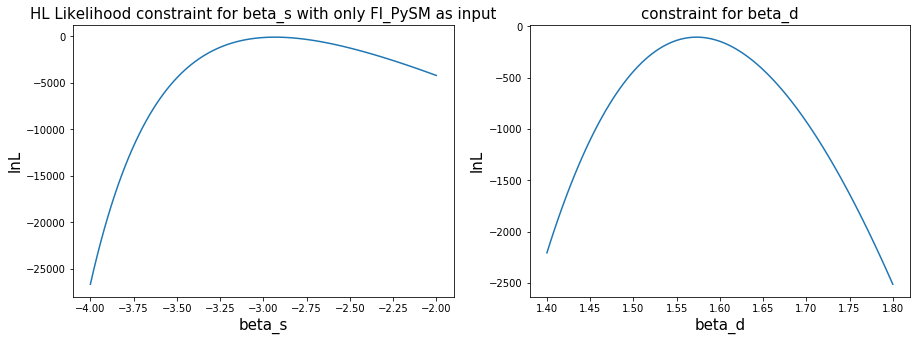

In [531]:
fig, ax = plt.subplots(1,2, figsize = (15,5 ))

ax[0].plot(slist, (lall_s))
ax[0].set_xlabel('beta_s', fontsize = 15);
ax[0].set_ylabel('lnL',fontsize = 15);
ax[0].set_title("HL Likelihood constraint for beta_s with only Fl_PySM as input",fontsize = 15)

plt.plot(dlist, lall_d)
plt.xlabel('beta_d', fontsize = 15);
plt.ylabel('lnL',fontsize = 15);
plt.title("constraint for beta_d",fontsize = 15)
plt.savefig('./fig_results/0803_HL_Likelihood_beta_s_beta_d.pdf', format = 'pdf')

#### likelihood for simple foreground model, to compare with Gaussian Likelihood

In [536]:
import Fg_template

In [537]:
imp.reload(Fg_template)

<module 'Fg_template' from '/home/jianyao/Likelihood/Fg_template.py'>

In [538]:
from Fg_template import sync_ps as sync_ps_v0
from Fg_template import dust_ps as dust_ps_v0
from Fg_template import corre_fore_simple

11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5,
       191.5

In [660]:
npara = 4; Nsim = 1; sbin = 1; ebin = 10

def prior(cube):
    
    r = cube[0]*0.3
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    epsilon = cube[3];
    
    return [r, beta_s, beta_d, epsilon]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim); Results = []

for n in range(0, Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2]
      
    def log_likelihood(cube, subtract = False):
        
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];
        epsilon = cube[3];

        cl_th_test = combine_ps(r_i)  ## combine the tensor bb and lensing bb
        
        fl_hat = sync_ps_v0(A_s_RJ, beta_s, lbin) + dust_ps_v0(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)
        
        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] + fl_hat
        
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=sbin, ebin = ebin); 

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested()
        results = sampler.results
    Results.append(results)
    
#     if n == 0 : 
#         samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
#     else: 
#         _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
#         samples = np.r_[samples, _samples];
#         weights = np.r_[weights, _weights];

4351it [00:14, 290.29it/s, +400 | bound: 15 | nc: 1 | ncall: 22417 | eff(%): 21.194 | loglstar:   -inf < -5.336 <    inf | logz: -15.257 +/-  0.216 | dlogz:  0.001 >  0.409]


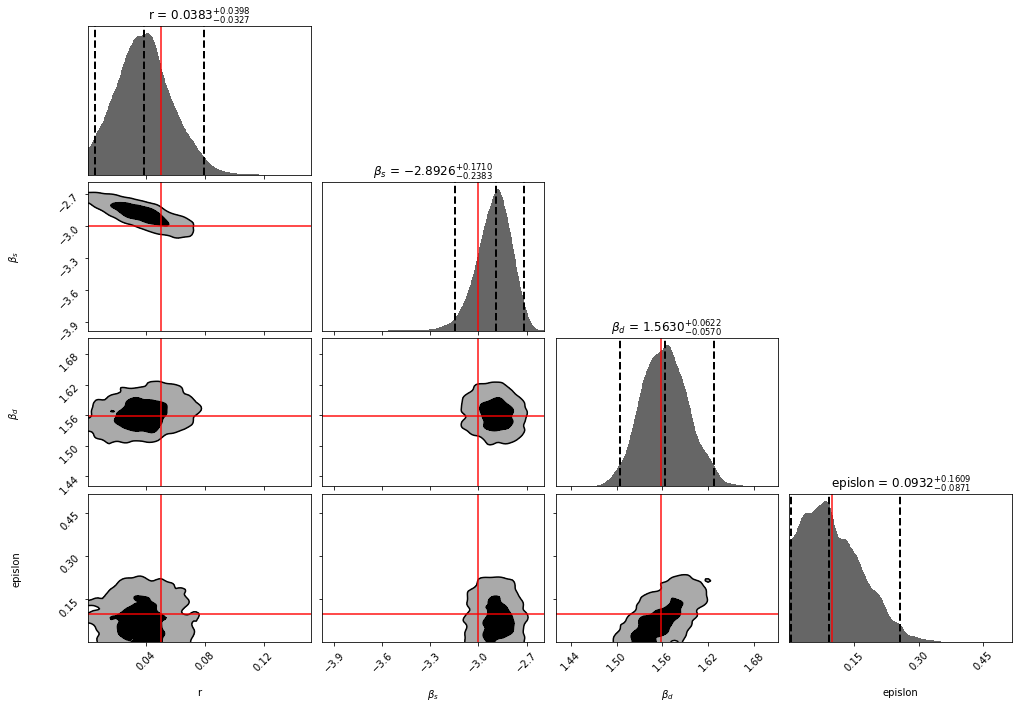

In [653]:
truth = np.array([0.05, -3.0, 1.558, 0.1])

labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

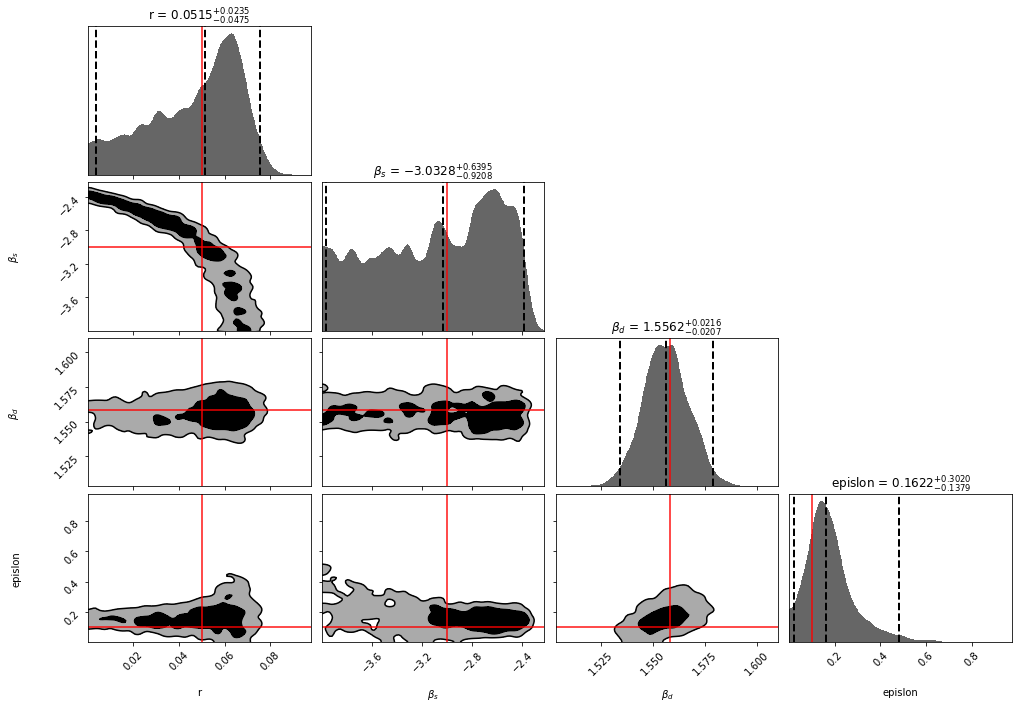

In [655]:
truth = np.array([0.05, -3.0, 1.558, 0.1])

labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

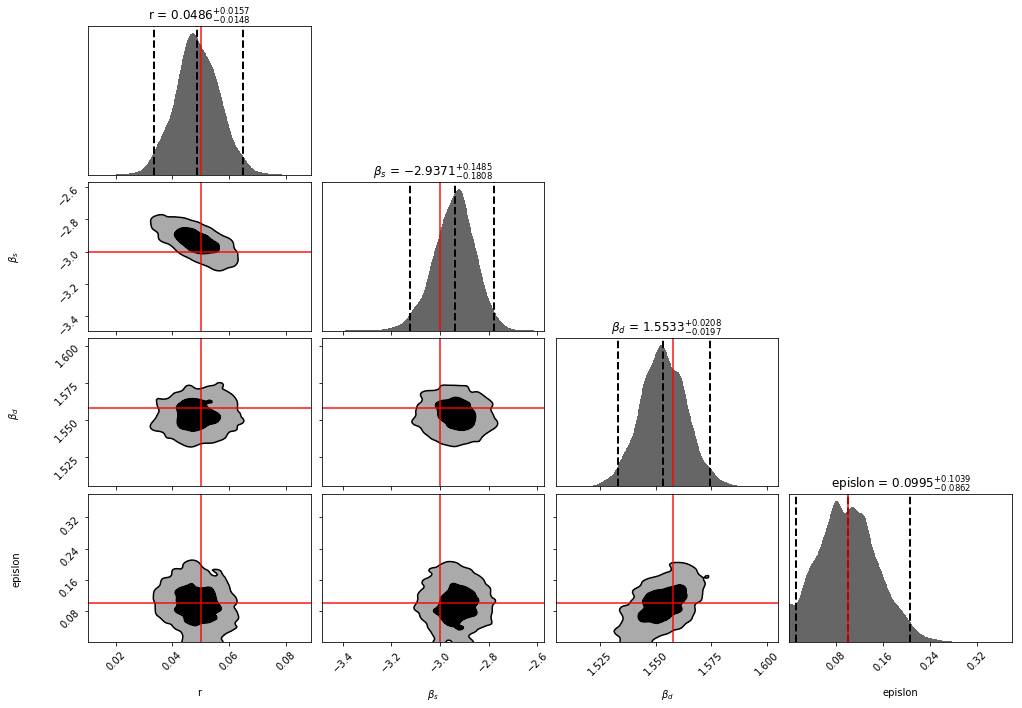

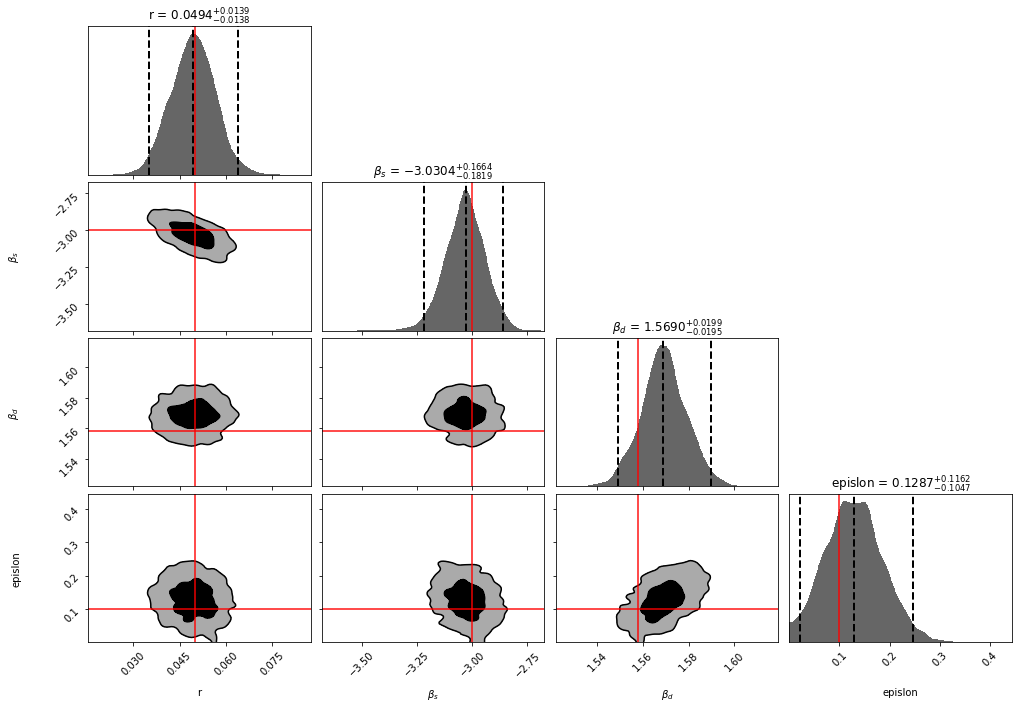

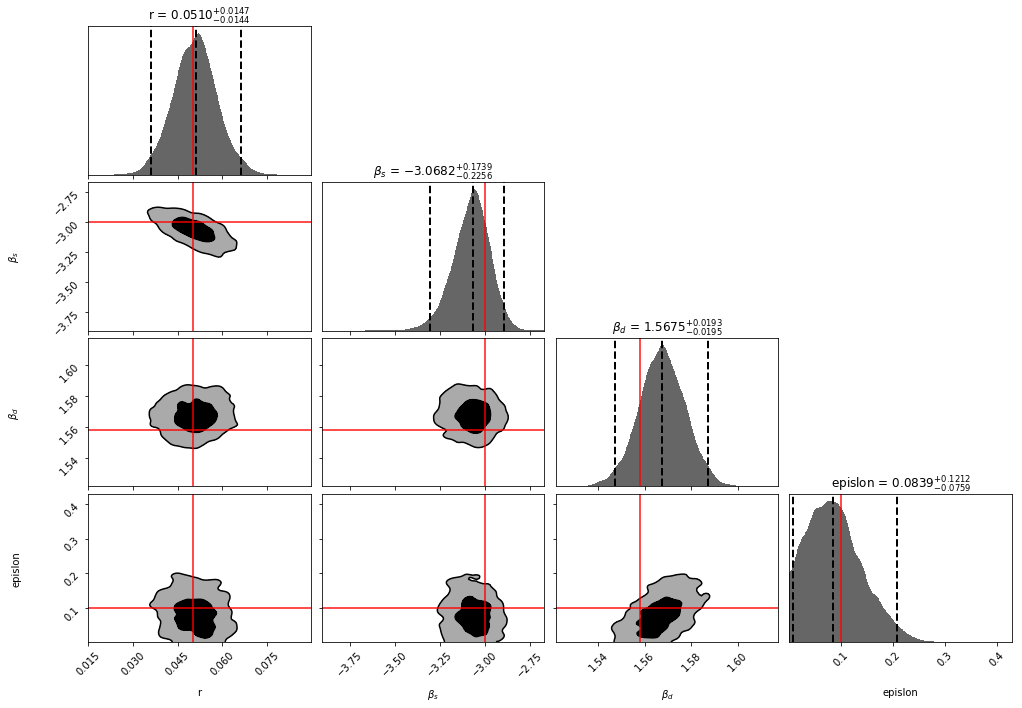

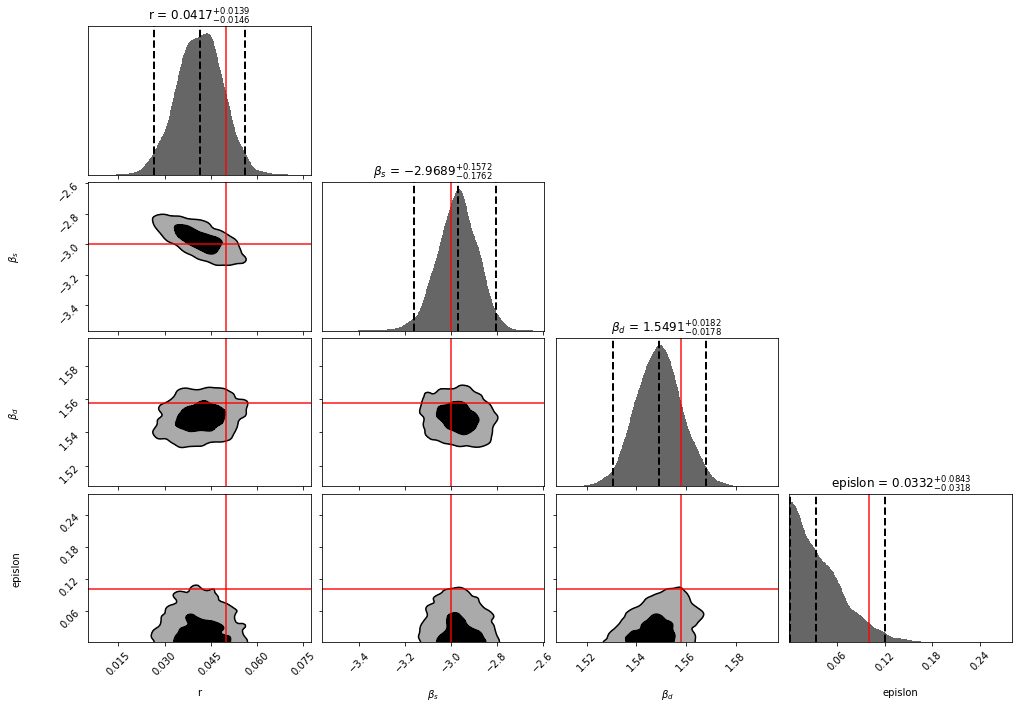

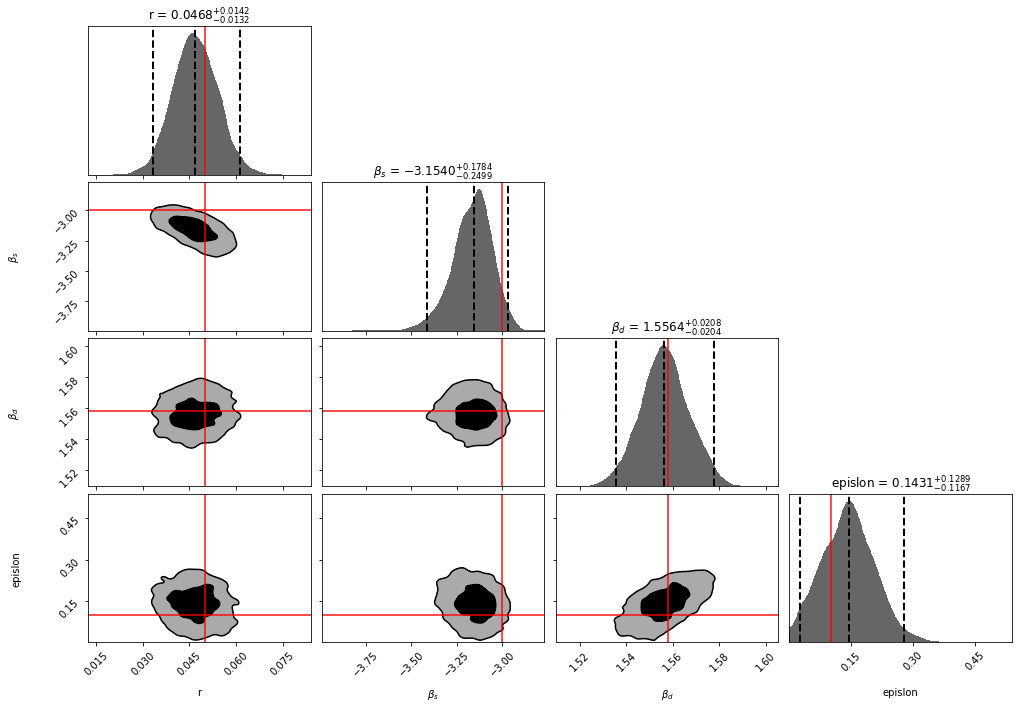

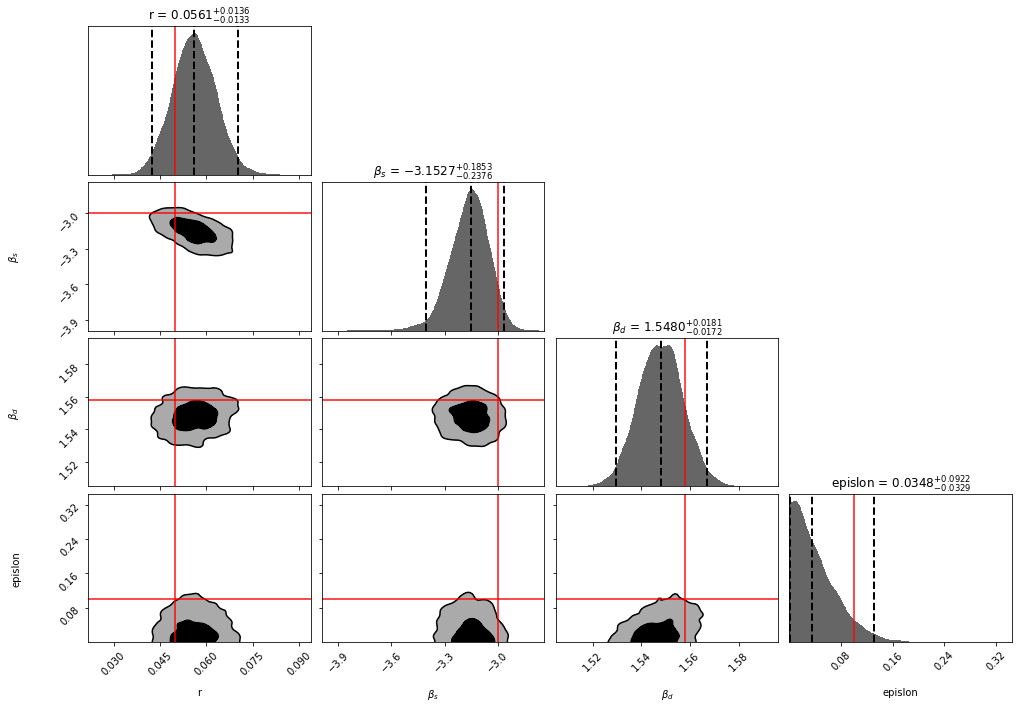

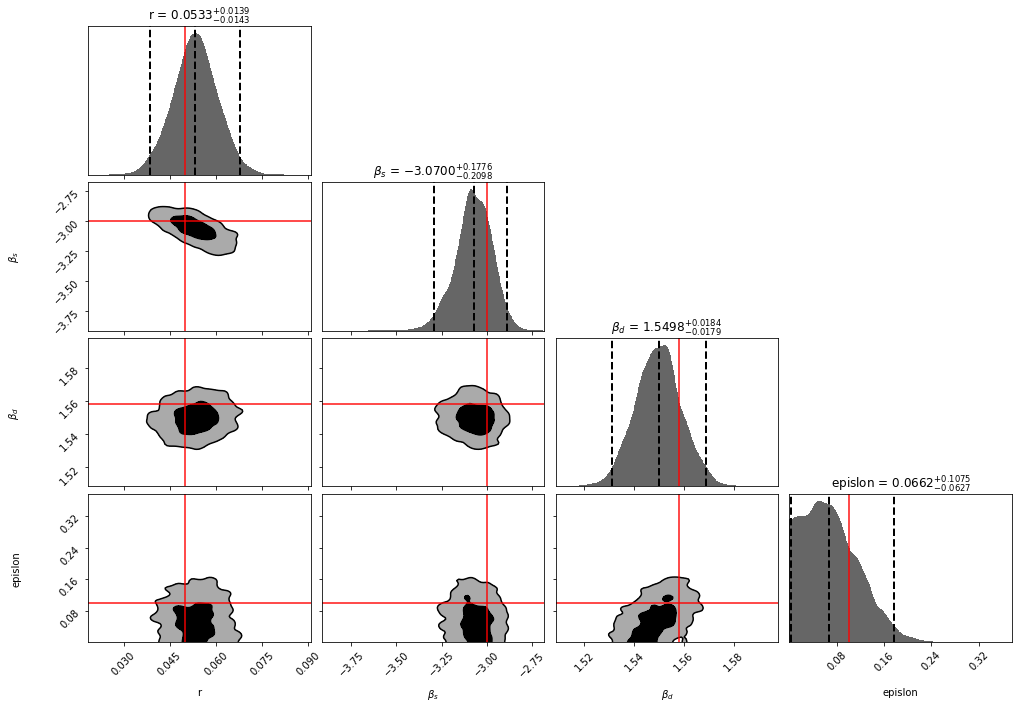

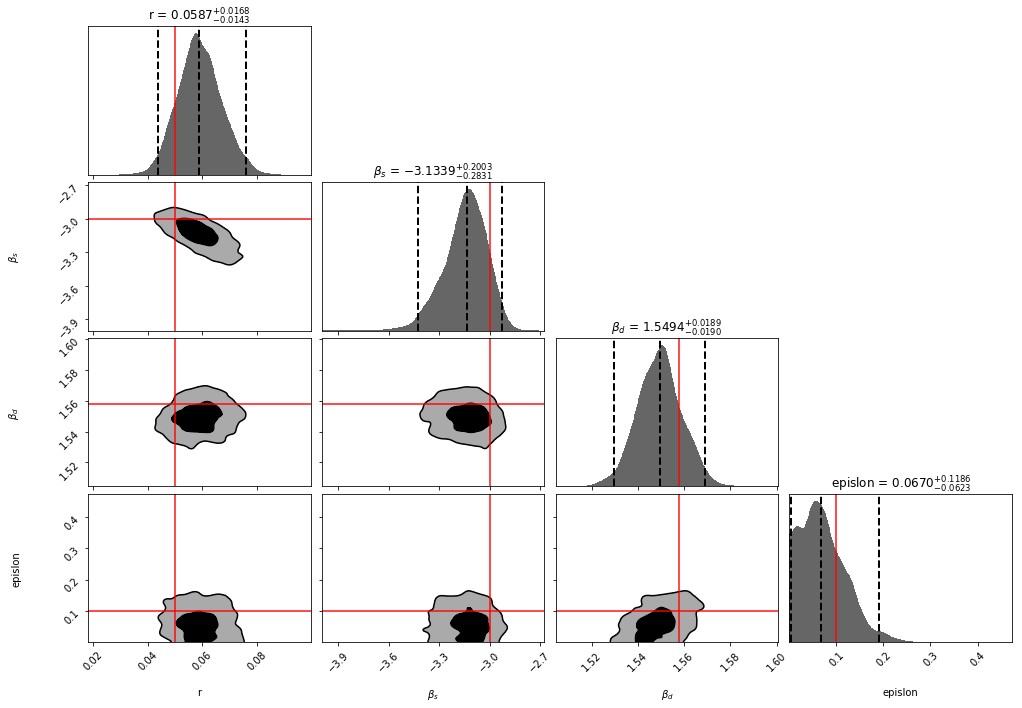

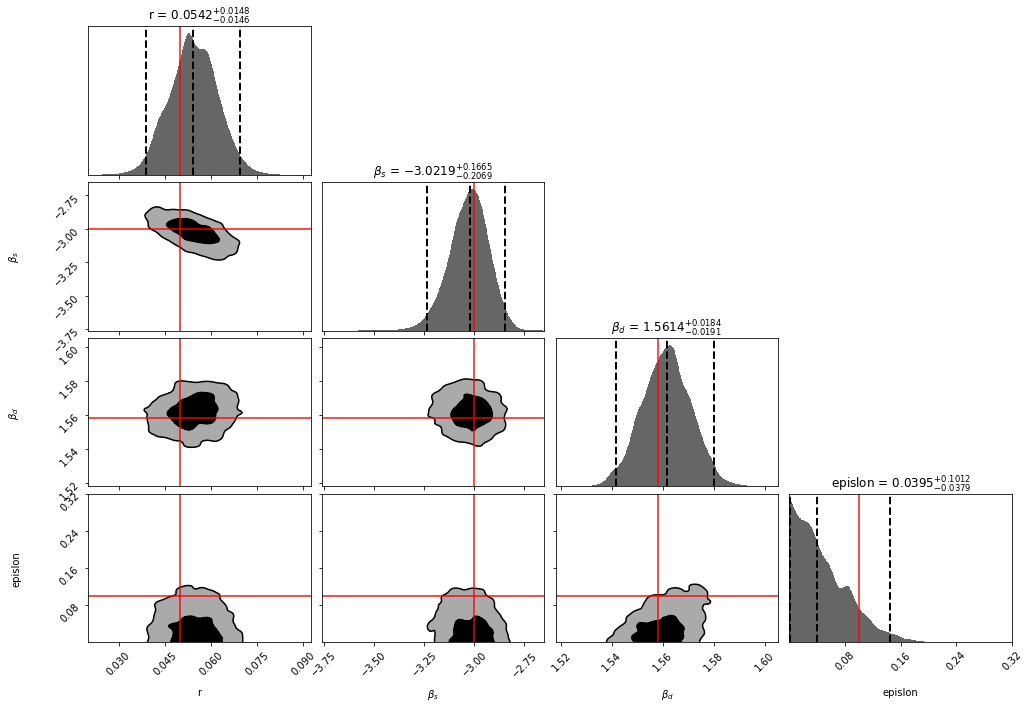

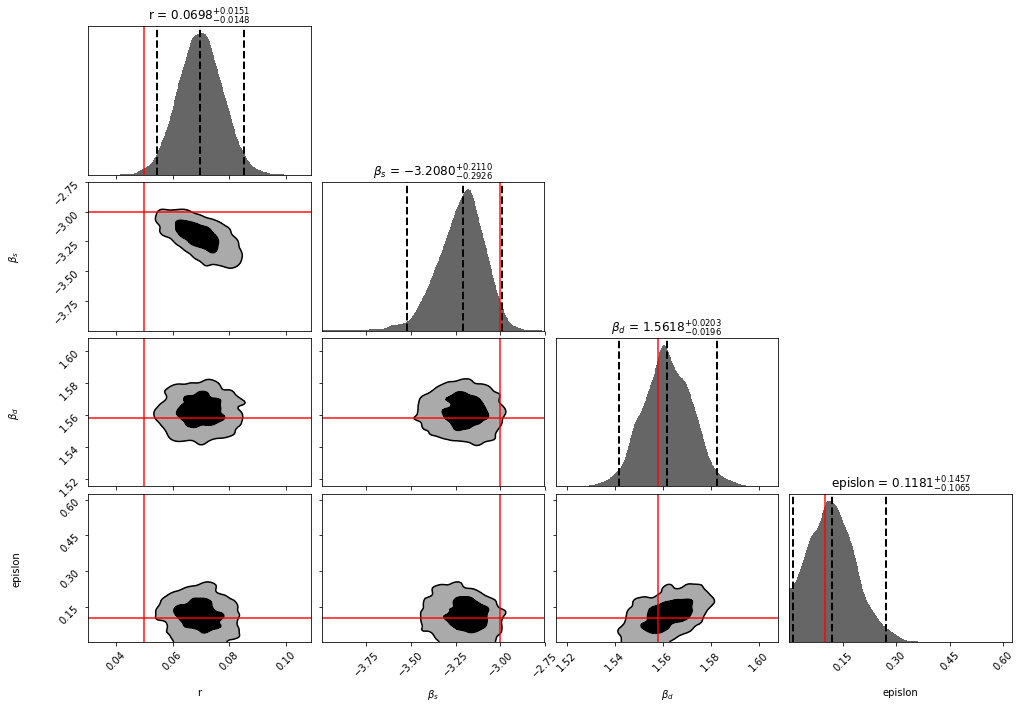

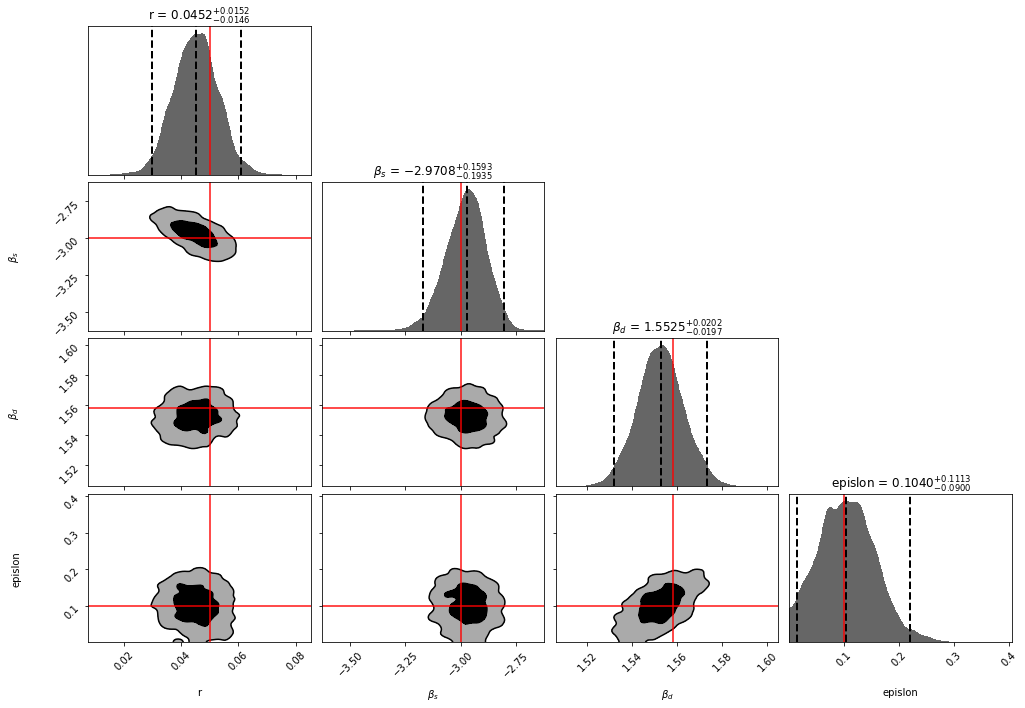

In [548]:
truth = np.array([0.05, -3.0, 1.558, 0.1])

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

#### likelihood

In [535]:
npara = 8; Nsim = 1; sbin = 0; ebin = 10

def prior(cube):
    
    r = cube[0]*0.1
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    
    # -1.2
    alpha_s = cube[3]*0.6 - 1.5
    
    #-0.5
    alpha_d = cube[4]*0.6 - 0.8
    
    epsilon = cube[5]*2 - 1
    
    A_s = cube[6]; A_d = cube[7] ## from 0 to 1; in uK_RJ units
    
    return [r, beta_s, beta_d, alpha_s, alpha_d, epsilon, A_s, A_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);

for n in range(Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2]
      
    def log_likelihood(cube, subtract = False):
        
        r_i = cube[0];
        beta_s = cube[1]; beta_d = cube[2];
        
        alpha_s = cube[3]; alpha_d = cube[4]; 
        
        epsilon = cube[5];
        
        A_s = cube[6]; A_d = cube[7]

        cl_th_test = combine_ps(r_i)  ## combine the tensor bb and lensing bb

        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s, leff, alpha_s, beta_s) + dust_ps(A_d, leff, alpha_d, beta_d) \
        + corre_fore(epsilon, A_d, A_s, leff, alpha_s, alpha_d, beta_s, beta_d);
        
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=sbin, ebin = ebin); 

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested()
        results = sampler.results

#     if n == 0 : 
#         samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
#     else: 
#         _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
#         samples = np.r_[samples, _samples];
#         weights = np.r_[weights, _weights];

5732it [00:37, 151.13it/s, +400 | bound: 28 | nc: 1 | ncall: 30155 | eff(%): 20.335 | loglstar:   -inf < -12.922 <    inf | logz: -26.346 +/-  0.256 | dlogz:  0.001 >  0.409]


#### run dynesty

In [276]:
resamples = dyfunc.resample_equal(samples, weights)

# print(np.mean(resamples[:,0]))
# print(np.std(resamples[:,0]))

# print(np.mean(resamples[:,1]))
# print(np.std(resamples[:,1]))

# print(np.mean(resamples[:,2]))
# print(np.std(resamples[:,2]))

/home/jianyao/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:163: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


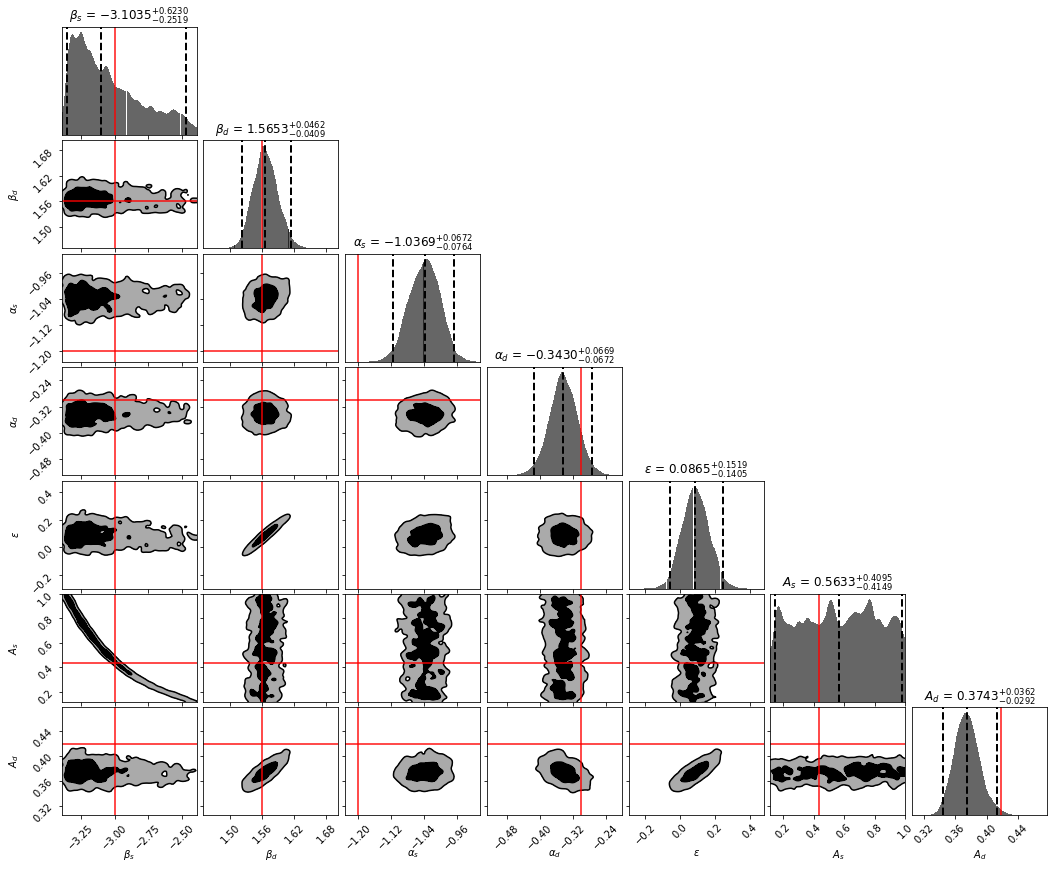

In [477]:
labels = [r'$\beta_s$', r'$\beta_d$', r'$\alpha_s$', r'$\alpha_d$', r'$\epsilon$', r'$A_s$', r'$A_d$']; 
fig, axes = plt.subplots(npara,npara, figsize=(15, 12))
axes = axes.reshape((npara,npara))

truth = [-3.0, 1.56, -1.2, -0.3,  0.55,0.434, 0.419]

fg, ax = dyplot.cornerplot(results,  truths=truth, title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85], fig = (fig, axes)) #0.1, 0.4, 0.65, 0.85

#### All samples from 100 simulations of CMB and Noise

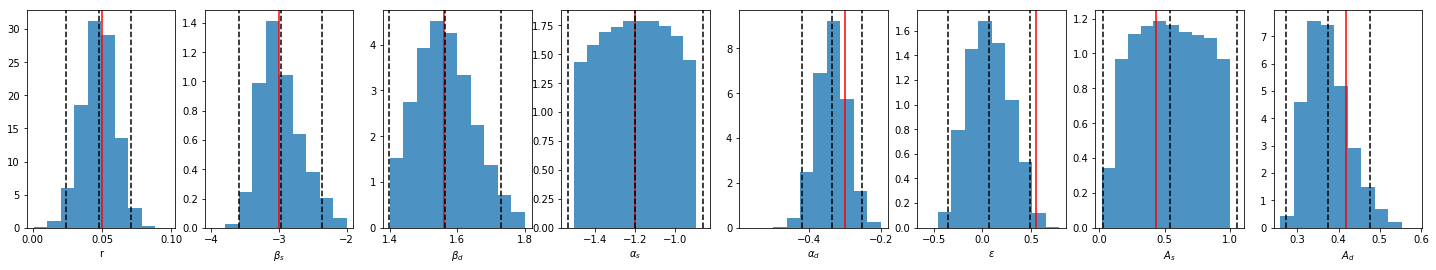

In [304]:

fig, axes = plt.subplots(1,npara, figsize = (25,4))

for m in range(npara):
    
    axes[m].hist(resamples[:,m], density=True, alpha = 0.8); 
    axes[m].axvline(truth[m], c = 'r')
    axes[m].axvline(np.mean(resamples[:,m]),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] +2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] - 2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].set_xlabel(r'%s'%labels[m])


plt.savefig('./fig_results/dynesty/0724_constraints_on_7parameters_2sigma_range.pdf', format = 'pdf')

In [298]:
np.std(resamples[:,0])

0.011719674514914043

#### comparision between Cl_hat and recovered best-fit

In [419]:
sample_i, weight_i = results.samples, np.exp(results.logwt - results.logz[-1])
# mean, cov = dyfunc.mean_and_cov(sample_i, weight_i)

best_fit = np.ones(npara);
for i in range(npara):
    best_fit[i] = dynesty.utils.quantile(sample_i[:,i], [0.5], weight_i)[0]

In [420]:
best_fit

array([ 0.04402445, -2.9597846 ,  1.4899429 , -1.23339822, -0.35069175,
       -0.05558405,  0.53796356,  0.33089746])

In [435]:
 r_i = best_fit[0]; beta_s = best_fit[1]; beta_d = best_fit[2]; alpha_s = best_fit[3]; alpha_d = best_fit[4]; epsilon = best_fit[5]; A_s = best_fit[6]; A_d = best_fit[7]

Cl_recover = combine_ps(r_i) + nl_mean_ali[2] + sync_ps(A_s, leff, alpha_s, beta_s) + dust_ps(A_d, leff, alpha_d, beta_d) + corre_fore(epsilon, A_d, A_s, leff, alpha_s, alpha_d, beta_s, beta_d);

Text(0, 0.5, '$\\mathcal{D}_{\\ell}$')

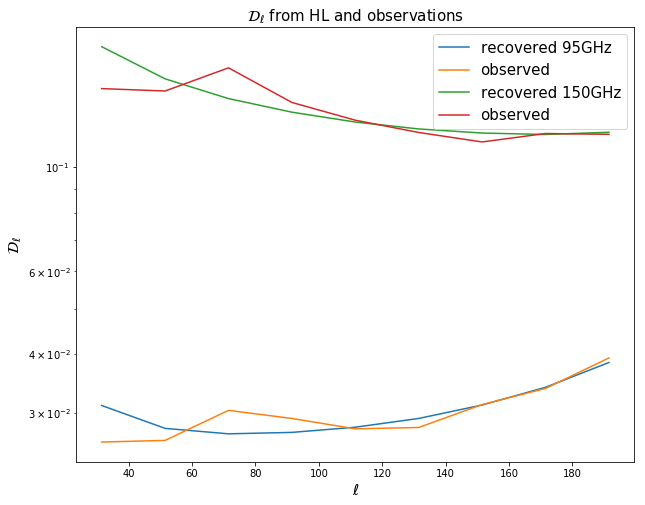

In [463]:
plt.figure(figsize = (10,8))
plt.title('$\mathcal{D}_{\ell}$ from HL and observations',fontsize = 15)

plt.plot(leff[sbin:], Cl_recover[:,0,0][sbin:], label = 'recovered 95GHz')
plt.plot(leff[sbin:], cl_hat_fore_ali[:,0,0][sbin:], label = 'observed')
plt.yscale('log')

plt.plot(leff[sbin:], Cl_recover[:,1,1][sbin:], label = 'recovered 150GHz')
plt.plot(leff[sbin:], cl_hat_fore_ali[:,1,1][sbin:], label = 'observed')

plt.legend(fontsize = 15)
plt.xlabel('$\ell$', fontsize = 15)
plt.ylabel('$\mathcal{D}_{\ell}$', fontsize = 15)

#### new comparision

In [661]:
sample_i, weight_i = results.samples, np.exp(results.logwt - results.logz[-1])
# mean, cov = dyfunc.mean_and_cov(sample_i, weight_i)

best_fit = np.ones(npara);
for i in range(npara):
    best_fit[i] = dynesty.utils.quantile(sample_i[:,i], [0.5], weight_i)[0]

In [662]:
best_fit

array([ 0.04857651, -2.93247363,  1.55354134,  0.1003623 ])

In [663]:
 r_i = best_fit[0]; beta_s = best_fit[1]; beta_d = best_fit[2]; epsilon = best_fit[3];

Cl_recover = combine_ps(r_i) + nl_mean_ali[2] + sync_ps_v0(A_s_RJ, beta_s, lbin) + dust_ps_v0(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)

In [665]:
Gau_best_fit = [0.717, -2.9956, 1.5558, 0.0459]

Gau_Cl_recover = combine_ps(Gau_best_fit[0]) + nl_mean_ali[2] + sync_ps_v0(A_s_RJ, Gau_best_fit[1], lbin) + dust_ps_v0(A_d_RJ, Gau_best_fit[2], lbin) + corre_fore_simple(Gau_best_fit[3], A_d_RJ, A_s_RJ, Gau_best_fit[1], Gau_best_fit[2], lbin)

Text(0, 0.5, '$\\mathcal{D}_{\\ell}$')

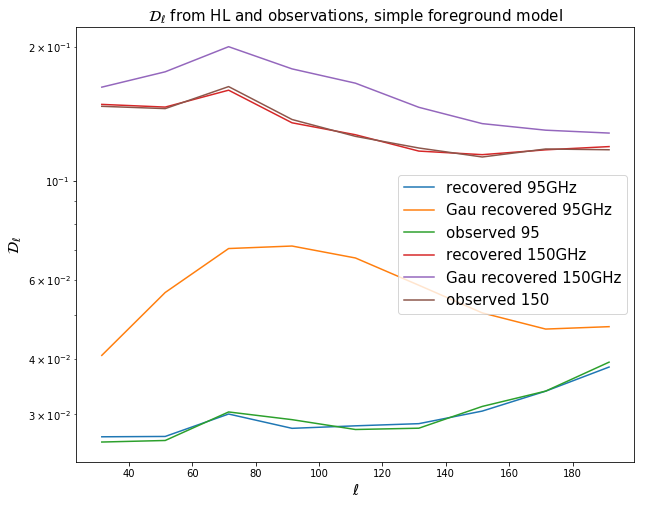

In [669]:
plt.figure(figsize = (10,8))
plt.title('$\mathcal{D}_{\ell}$ from HL and observations, simple foreground model',fontsize = 15)

plt.plot(leff[sbin:], Cl_recover[:,0,0][sbin:], label = 'recovered 95GHz')
plt.plot(leff[sbin:], Gau_Cl_recover[:,0,0][sbin:], label = 'Gau recovered 95GHz')

plt.plot(leff[sbin:], cl_hat_fore_ali[:,0,0][sbin:], label = 'observed 95')
plt.yscale('log')

plt.plot(leff[sbin:], Cl_recover[:,1,1][sbin:], label = 'recovered 150GHz')
plt.plot(leff[sbin:], Gau_Cl_recover[:,1,1][sbin:], label = 'Gau recovered 150GHz')

plt.plot(leff[sbin:], cl_hat_fore_ali[:,1,1][sbin:], label = 'observed 150')

plt.legend(fontsize = 15)
plt.xlabel('$\ell$', fontsize = 15)
plt.ylabel('$\mathcal{D}_{\ell}$', fontsize = 15)